### Imports and Functions for calulating Attributions

In [2]:
from builtins import print
import numpy as np
import pandas as pd
import matplotlib
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.utils.generic_utils import CustomObjectScope
#from tensorflow.keras.utils import CustomObjectScope

import tensorflow_addons as tfa

matplotlib.use('agg')
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'
import os
import operator

#import utils

from utils.constants import UNIVARIATE_DATASET_NAMES as DATASET_NAMES
from utils.constants import UNIVARIATE_DATASET_NAMES_2018 as DATASET_NAMES_2018
from utils.constants import ARCHIVE_NAMES  as ARCHIVE_NAMES
from utils.constants import CLASSIFIERS
from utils.constants import ITERATIONS
from utils.constants import MTS_DATASET_NAMES

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import LabelEncoder

import tensorflow.keras as keras

from scipy.interpolate import interp1d
from scipy.io import loadmat

In [9]:
root_dir = "G:/My Drive/master thesis/code/dl-4-tsc-mtl"

def readucr(filename):
    print(filename)
    data = np.loadtxt(filename, delimiter=',')
    Y = data[:, 0]
    X = data[:, 1:]
    return X, Y

def read_dataset(root_dir, archive_name, dataset_name):

    datasets_dict = {}
    cur_root_dir = root_dir.replace('-temp', '')

    file_name = cur_root_dir + '/archives/' + archive_name + '/' + dataset_name + '/' + dataset_name
    x_train, y_train = readucr(file_name + '_TRAIN')
    x_test, y_test = readucr(file_name + '_TEST')
    datasets_dict[dataset_name] = (x_train.copy(), y_train.copy(), x_test.copy(),
                                   y_test.copy())
    
    return datasets_dict


def viz_cam(root_dir, train_data=True, task1= True):
    import tensorflow.keras as keras
    import sklearn
    
    classifier = 'fcn_mt'
    archive_name = 'ucr'
    dataset_name = 'GunPoint'

    max_length = 2000
    datasets_dict = read_dataset(root_dir, archive_name, dataset_name)
    
    if train_data == True:
        x_train = datasets_dict[dataset_name][0]
        y_train = datasets_dict[dataset_name][1]
    else: 
        x_train = datasets_dict[dataset_name][2]
        y_train = datasets_dict[dataset_name][3]
    
    y_test = datasets_dict[dataset_name][3]
    
    # transform to binary labels
    enc = sklearn.preprocessing.OneHotEncoder()
    enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    y_train_binary = enc.transform(y_train.reshape(-1, 1)).toarray()

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)


    with CustomObjectScope({'InstanceNormalization':tfa.layers.InstanceNormalization()}):
        model = keras.models.load_model(
        root_dir + '/results/' + classifier + '/' + archive_name + '_itr_4' + '/' + dataset_name + '/best_model.hdf5',compile=False)

    # filters
    relu, softm = (-4,-2) if task1 else (-4,-1)
    
    w_k_c = model.layers[softm].get_weights()[0]  # weights for each filter k for each class c

    # the same input
    new_input_layer = model.inputs

    # Output is both the original as well as the before last layer
    # layers[-3] : KerasTensor(type_spec=TensorSpec(shape=(None, 150, 128), dtype=tf.float32, name=None), name='activation_8/Relu:0', description="created by layer 'activation_8'") 
    # layers[-1] : KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")

    new_output_layer = [model.layers[relu].output, model.layers[softm].output]

    new_feed_forward = keras.backend.function(new_input_layer, new_output_layer)
    classes = np.unique(y_train)
    
    attr = []

    for c in classes:
        #plt.figure()
        count = 0
        #find all time series for a class
        ts_class = np.where(y_train == c)
        #get time series data 
        c_x_train = x_train[ts_class]
        for idx,ts in enumerate(c_x_train):
            ts_nr=ts_class[0][idx]
            ts = ts.reshape(1, -1, 1)
            [conv_out, predicted] = new_feed_forward([ts])
            pred_label = np.argmax(predicted)
            orig_label = np.argmax(enc.transform([[c]]))
            if True: 
                cas = np.zeros(dtype=np.float64, shape=(conv_out.shape[1]))
                for k, w in enumerate(w_k_c[:, orig_label]):
                    cas += w * conv_out[0, :, k] 
                minimum = np.min(cas)
                cas = cas - minimum
                cas = cas / max(cas)
                cas = cas * 100
                x = np.linspace(0, ts.shape[1] - 1, max_length, endpoint=True)
                # linear interpolation to smooth
                f = interp1d(range(ts.shape[1]), ts[0, :, 0])
                y = f(x)
                f = interp1d(range(ts.shape[1]), cas)
                cas = f(x).astype(int)
                attr.append([ts_nr,x,y,cas])
    return attr

attr = viz_cam(root_dir, True)


G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TRAIN
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TEST


### TED Explanation. 

In [5]:
def get_len_and_step_size(attributions, slices=5):
    attr_len  = len(attributions)
    step_size = int(attr_len / slices)
    return attr_len,step_size

G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TRAIN
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TEST
3


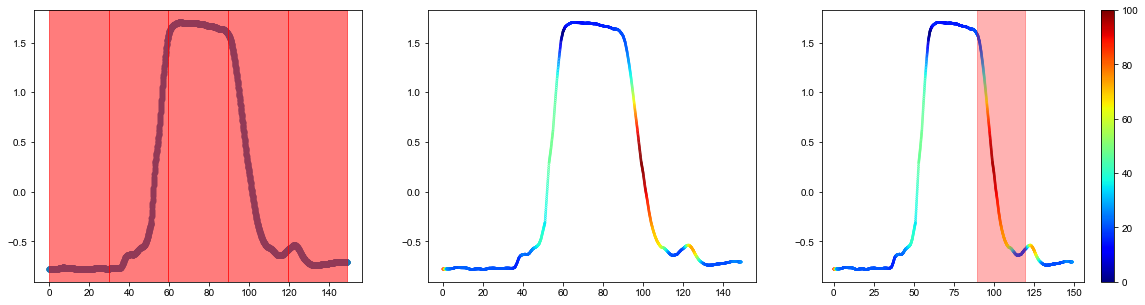

In [108]:
%matplotlib inline

root_dir = "G:/My Drive/master thesis/code/dl-4-tsc-mtl"
attr = viz_cam(root_dir, True)

ts=0
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

sp = plt.scatter(x=attr[ts][1], y=attr[ts][2], c=attr[ts][3], cmap='jet', marker='.', s=2, vmin=0, vmax=100, linewidths=0.0)

sl = None
mean_att = 0
l1,l2 = (0,0)
attr_len, step_size = get_len_and_step_size(attr[0][3],5)
for i,x in enumerate(range(0,attr_len,step_size)):

    lower_bound = attr[ts][1][x]
    upper_bound = attr[ts][1][x+step_size-1]
    axes[0].axvspan(lower_bound,upper_bound,color="red",alpha=0.3)
    cur_mean = attr[ts][3][x:x+step_size-1].mean()
    if cur_mean > mean_att: 
        sl = i
        mean_att = cur_mean 
        l1,l2 = (lower_bound, upper_bound)

axes[0].scatter(x=attr[ts][1], y=attr[ts][2], linewidths=0.0)
axes[1].scatter(x=attr[ts][1], y=attr[ts][2], c=attr[ts][3], cmap='jet', marker='.', s=2, vmin=0, vmax=100, linewidths=2.0)
axes[2].scatter(x=attr[ts][1], y=attr[ts][2], c=attr[ts][3], cmap='jet', marker='.', s=2, vmin=0, vmax=100, linewidths=2.0)

fig.colorbar(sp)
axes[2].axvspan(l1,l2,color="red",alpha=0.3)

for i,x in enumerate(range(0,2000,400)):
    axes[0].axvspan(attr[ts][1][x],attr[ts][1][x+399],color="red",alpha=0.3)
    

print(sl)

In [11]:
from collections import Counter

def highest_mean_attribution(att,slices): 
    attr_len, step_size = get_len_and_step_size(att,slices)
    candidates = []
    for x in range(0,attr_len,step_size):
        candidates.append(att[x:x+step_size-1].mean())
    return np.argmax(candidates)

In [12]:
root_dir = "G:/My Drive/master thesis/code/dl-4-tsc-mtl"
archive_name = 'ucr'
dataset_name = 'GunPoint'

datasets_dict = read_dataset(root_dir, archive_name, dataset_name)

x_train = datasets_dict[dataset_name][0]
y_train = datasets_dict[dataset_name][1]
x_test = datasets_dict[dataset_name][2]
y_test = datasets_dict[dataset_name][3]

train_attr = viz_cam(root_dir, True)
test_attr = viz_cam(root_dir, False)

def create_explanations(x,attributions):
    explanations = np.zeros((x.shape[0], x.shape[1]+1))
    labels = []
    for ts in attributions: 
        ts_nr = ts[0]
        x_values = x[ts_nr]
        label = highest_mean_attribution(ts[3],5)
        labels.append(label)
        explanations[ts_nr] = np.concatenate((label,x_values), axis=None)
    print(Counter(labels), len(labels))
    return explanations

x_train_exp = create_explanations(x_train, train_attr)
x_test_exp  = create_explanations(x_test, test_attr)

G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TRAIN
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TEST
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TRAIN
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TEST
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TRAIN
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TEST
Counter({3: 23, 0: 17, 1: 5, 4: 4, 2: 1}) 50
Counter({3: 76, 0: 32, 4: 17, 1: 16, 2: 9}) 150


In [14]:
def save_dataset(data, root_dir, archive_name,dataset_name,train=True):
    ext = "_Exp"
    dataset_name = dataset_name + "_Exp"
    add = "_TRAIN" if train else "_TEST"
    np.savetxt(root_dir + '/archives/' + archive_name + '/' + dataset_name + '/' + dataset_name + add , data, delimiter=',')
    print("Successfully done.")

save_dataset(x_train_exp,root_dir,archive_name,dataset_name,train=True)
save_dataset(x_test_exp,root_dir,archive_name,dataset_name,train=False)

Successfully done.
Successfully done.


### Second iteration: 

#### Balancing the classes 

In [147]:
#Originial Dataset: 
train_path = "G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TRAIN"
train_data = np.loadtxt(train_path, delimiter=',')
test_path = "G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TEST"
test_data = np.loadtxt(test_path, delimiter=',')
#Concetante both arrays 
new_x = np.concatenate((train_data,test_data), axis=0)
new_x_exp = np.concatenate((x_train_exp, x_test_exp), axis=0)
print(new_x.shape,new_x_exp.shape)
#Counter, for GunPoint delete timeseries with segment 2

print(Counter(new_x_exp[:,0])) 
#Delete 2
filter_out = np.where(new_x_exp[:,0] == 2.0)[0]
#new_x = new_x[~np.isin(np.arange(new_x.size), filter_out)]
new_x = np.delete(new_x, filter_out, axis=0)
new_x_exp = np.delete(new_x_exp, filter_out, axis=0)

#12 in the training, training set approximately ~ 50 as original one 

import math
#keep roughly 0.7 percent for training. => highly unbalanced training dataset
keep = math.floor(sorted(list(Counter(new_x_exp[:,0]).values()),reverse=True)[-1]*0.7) 

#for list(Counter(new_x_exp[:,0]).keys())

train_idx = [np.random.choice(np.where(new_x_exp[:,0] == i)[0], keep, replace=False) \
             for i in list(Counter(new_x_exp[:,0]).keys())]

#print(np.random.choice(np.where(new_x_exp[:,0] == 3)[0], keep, replace=False))
#print([i for i in list(Counter(new_x_exp[:,0]).keys())])


train_idx = np.array(train_idx).flatten()

#Train data
new_x_train = new_x[train_idx]
new_x_exp_train = new_x_exp[train_idx]

#Test data
new_x_test  = new_x[~train_idx]
new_x_exp_test = new_x_exp[~train_idx]


print("Final train dataset Task1/Task2:", Counter(new_x_train[:,0]), Counter(new_x_exp_train[:,0]))
print("Final test dataset Task1/Task2:", Counter(new_x_test[:,0]), Counter(new_x_exp_test[:,0]))

(200, 151) (200, 151)
Counter({3.0: 99, 0.0: 49, 1.0: 21, 4.0: 21, 2.0: 10})
Final train dataset Task1/Task2: Counter({2.0: 30, 1.0: 26}) Counter({3.0: 14, 1.0: 14, 4.0: 14, 0.0: 14})
Final test dataset Task1/Task2: Counter({2.0: 31, 1.0: 25}) Counter({3.0: 31, 0.0: 15, 4.0: 5, 1.0: 5})


In [149]:
def save_dataset(data, root_dir, archive_name,dataset_name,train=True, original=False):
    ext = "_Exp" if not original else ""
    dataset_name = dataset_name + ext
    add = "_TRAIN" if train else "_TEST"
    np.savetxt(root_dir + '/archives/' + archive_name + '/' + dataset_name + '/' + dataset_name + add , data, delimiter=',')
    print("Successfully done.")

#Save balanced class original task 1
"""
save_dataset(new_x_train,root_dir,archive_name,dataset_name,train=True, original=True)
save_dataset(new_x_test,root_dir,archive_name,dataset_name,train=False, original=True)    

"""
#Save balanced class expl task 2   
save_dataset(new_x_exp_train,root_dir,archive_name,dataset_name,train=True)
save_dataset(new_x_exp_test,root_dir,archive_name,dataset_name,train=False)

Successfully done.
Successfully done.
Successfully done.
Successfully done.
